# K-Means Clustering


In [95]:
# Importamos las librerias a usar
import random 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets import make_blobs 
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.metrics import silhouette_score

## Acerca del conjunto de datos `Cust_Segmentation.csv`

Este dataset contiene información sobre clientes, incluyendo su edad, educación, años empleados, ingresos, deudas de tarjetas de crédito, otras deudas, historial de incumplimiento de pagos, dirección y ratio de deuda-ingresos. El objetivo de este proyecto es aplicar técnicas de segmentación de clientes para dividir la base de clientes en grupos con características similares. Esto permitirá a la empresa dirigir sus estrategias de marketing de manera más efectiva, identificando grupos de clientes con mayor probabilidad de compra o suscripción a servicios, así como aquellos que puedan necesitar estrategias de retención específicas. [Dataset source](https://www.kaggle.com/datasets/somesh24/customer-segmentation)

El dataset Contiene las siguientes columnas:
- Customer Id: Identificador único del cliente.
- Age: Edad del cliente.
- Edu: Nivel educativo del cliente.
- Years Employed: Años de empleo del cliente.
- Income: Ingreso del cliente.
- Card Debt: Deuda de tarjeta de crédito del cliente.
- Other Debt: Otra deuda del cliente.
- Defaulted: Indicador de si el cliente ha incumplido.
- Address: Dirección del cliente.
- DebtIncomeRatio: Ratio deuda/ingreso del cliente.


In [96]:
# Se importa el archivo
df = pd.read_csv("Cust_Segmentation.csv")
# visualizamos el df
df.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2


EDA

In [97]:
# Verificamos el tipo de dato en las columnas 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   Address          850 non-null    object 
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 66.5+ KB


In [98]:
# Contamos los valores duplicados
print(f'Verifica duplicados: ',df.duplicated().value_counts())
# Contamos los valores nulos
print(f'Verificar datos nulos:\n',df.isnull().sum())

Verifica duplicados:  False    850
Name: count, dtype: int64
Verificar datos nulos:
 Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
Address              0
DebtIncomeRatio      0
dtype: int64


la columna Address en este dataset es una variable categórica. El algoritmo k-means no es directamente aplicable a variables categóricas porque la función de distancia euclidiana no es realmente significativa para variables discretas. Por lo tanto, vamos a eliminar esta característica.

In [99]:
# Elimina la columna 'Address'
df.drop('Address', axis=1, inplace=True)

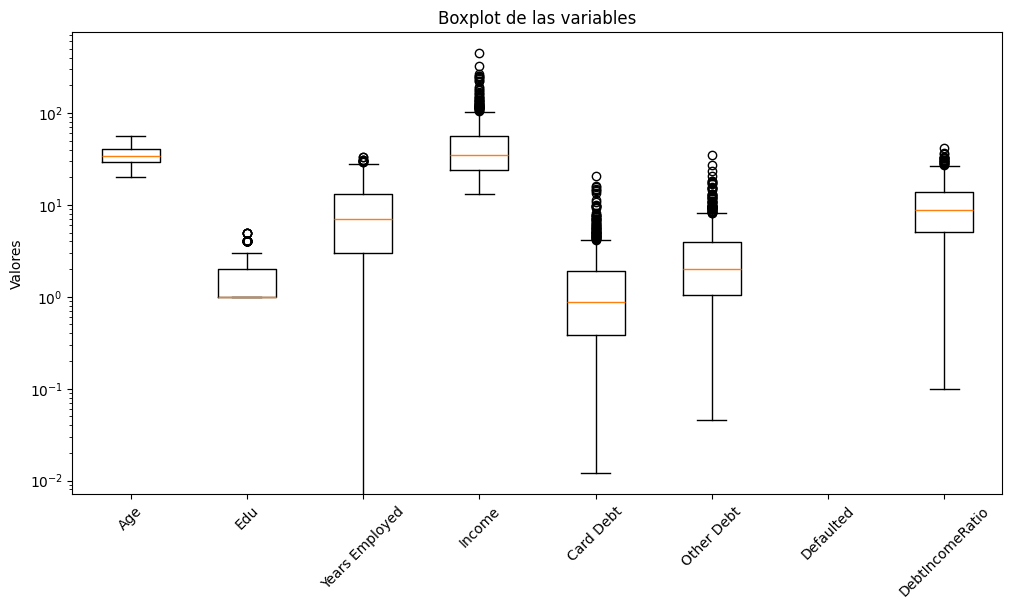

In [100]:
# Crear el gráfico de caja
plt.figure(figsize=(12, 6))
plt.boxplot(df.drop(columns='Customer Id').values, labels=df.drop(columns='Customer Id').columns)
plt.xticks(rotation=45)
plt.yscale('log')  # Escala logarítmica para enfocar los datos
plt.ylabel('Valores')
plt.title('Boxplot de las variables')
plt.show()

En el análisis exploratorio de datos (EDA), se identificaron varias columnas con valores atípicos, lo cual parece normal en este caso. Por ejemplo, no es inusual que entre las 850 personas en el dataset algunas tengan más formación educativa que otras, al igual que ocurre con los ingresos y las deudas de tarjetas, lo que puede aumentar el ratio de endeudamiento.

In [101]:
# Estadisticas por columna
df.describe()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.00000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,425.50000,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,245.51816,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,1.00000,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,213.25000,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,425.50000,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,637.75000,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,850.00000,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


Este resumen estadístico proporciona información útil sobre las diferentes variables del dataset:

- Age: La edad promedio de los clientes en el dataset es de aproximadamente 35 años, con una desviación estándar de aproximadamente 8 años. La edad mínima es 20 años y la máxima es 56 años.
- Edu: El nivel educativo promedio es de alrededor de 1.71, con un máximo de 5 y un mínimo de 1. Esto sugiere que la mayoría de los clientes tienen un nivel educativo bajo.
- Years Employed: Los clientes tienen un promedio de aproximadamente 8.57 años de empleo, con una desviación estándar de aproximadamente 6.78 años. El mínimo es 0 años (posiblemente desempleados) y el máximo es 33 años.
- Income: El ingreso promedio de los clientes es de aproximadamente 46.68, con una desviación estándar de aproximadamente 38.54. El ingreso mínimo es 13 y el máximo es 446.
- Card Debt y Other Debt: Las deudas promedio en tarjetas y otras deudas son de 1.58 y 3.08 respectivamente. Ambas tienen una amplia variabilidad en los datos, como se indica por sus desviaciones estándar de 2.13 y 3.40 respectivamente.
Defaulted: El 26.14% de los clientes han incumplido en sus pagos.
DebtIncomeRatio: El ratio promedio de deuda-ingresos es de aproximadamente 10.17, con una desviación estándar de aproximadamente 6.72. El mínimo es 0.1 y el máximo es 41.3.

#### Estándar de los datos

In [102]:
X = df.values[:,1:]# Elimina la columna ID
X = np.nan_to_num(X) # Convertimos los valores nulos a 0
X_scaler = StandardScaler().fit_transform(X) # Estandarizamos los datos
X_scaler

array([[ 0.74291541,  0.31212243, -0.37878978, ..., -0.59048916,
        -0.52379654, -0.57652509],
       [ 1.48949049, -0.76634938,  2.5737211 , ...,  1.51296181,
        -0.52379654,  0.39138677],
       [-0.25251804,  0.31212243,  0.2117124 , ...,  0.80170393,
         1.90913822,  1.59755385],
       ...,
       [-1.24795149,  2.46906604, -1.26454304, ...,  0.03863257,
         1.90913822,  3.45892281],
       [-0.37694723, -0.76634938,  0.50696349, ..., -0.70147601,
        -0.52379654, -1.08281745],
       [ 2.1116364 , -0.76634938,  1.09746566, ...,  0.16463355,
        -0.52379654, -0.2340332 ]])

Antes de profundizar en nuestro análisis, es crucial estandarizar nuestros datos. La estandarización ajusta las escalas de las características para que tengan una media de 0 y una desviación estándar de 1. Como se observó en el boxplot, se detectaron valores atípicos que requirieron el uso de una escala logarítmica.

### Modelo

In [160]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 10)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 2 0 0 1 2 0 2 0 2 2 0 0 0 0 0 0 0 2 0 0 0 0 2 2 2 0 0 2 0 2 0 0 0 0 0 0
 0 0 2 0 2 0 1 0 2 0 0 0 2 2 0 0 2 2 0 0 0 2 0 2 0 2 2 0 0 2 0 0 0 2 2 2 0
 0 0 0 0 2 0 2 2 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 2 0 2 0
 0 0 0 0 0 0 2 0 2 2 0 2 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 2 0
 0 0 0 0 2 0 0 2 0 2 0 0 2 1 0 2 0 0 0 0 0 0 1 2 0 0 0 0 2 0 0 2 2 0 2 0 2
 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 2 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0 2 0 2 2 0 0 0 0 0 0
 0 0 0 2 2 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 2 0 2 2 0
 0 0 0 0 2 0 0 0 0 0 0 2 0 0 2 0 0 2 0 0 0 0 0 2 0 0 0 1 0 0 0 2 0 2 2 2 0
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 2 0 0 2 0 0 0 0 2 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 1
 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 2 0 1 0 0 0 0 2 0 2 2 2 0 0 2 2 0 0 0 0 0 0
 0 2 0 0 0 0 2 0 0 0 2 0 

Podemos verificar los valores del centroide promediando las características en cada grupo.

In [164]:
df['k_means']= labels # Crea la columna K_means
df.groupby('k_means').mean() # Agrupa por la columna K_means

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
k_means,,,,,,,,,
0,432.468413,32.964561,1.614792,6.374422,31.164869,1.032541,2.104133,0.285185,10.094761
1,410.166667,45.388889,2.666667,19.555556,227.166667,5.678444,10.907167,0.285714,7.322222
2,402.295082,41.333333,1.956284,15.256831,83.928962,3.103639,5.765279,0.171233,10.724590


Ahora, veamos la distribución de clientes según su 'Age' e 'Income':

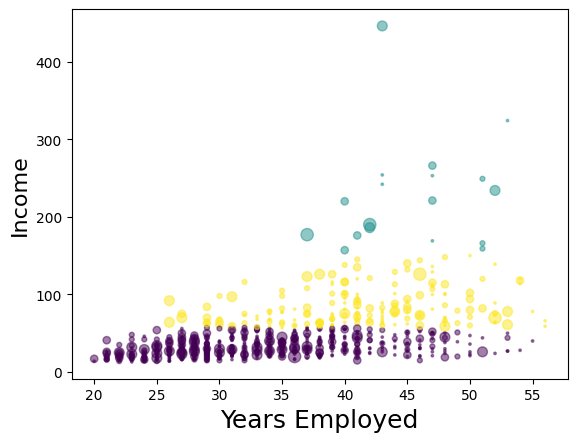

In [176]:
# Calcula el área de los círculos proporcional al cuadrado de la edad
area = np.pi * (X[:, 1])**2  
# Crea un gráfico de dispersión
plt.scatter(X[:, 0], X[:, 3], s=area, c=labels.astype(float), alpha=0.5)
# Etiqueta del eje x
plt.xlabel('Age', fontsize=18)
# Etiqueta del eje y
plt.ylabel('Income', fontsize=16)
# Muestra el gráfico
plt.show()

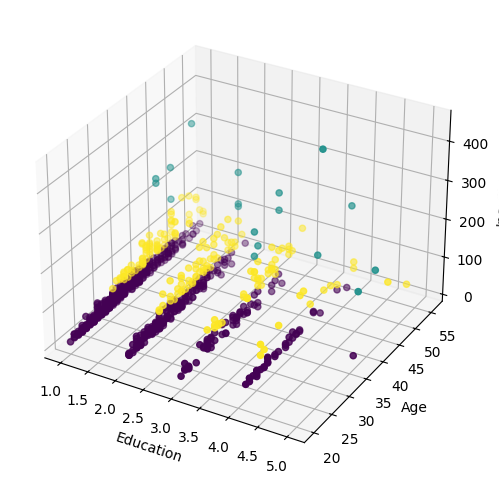

In [166]:
# Crear una figura con un tamaño de 12x6 pulgadas
fig = plt.figure(figsize=(12, 6))
# Limpiar la figura actual para evitar superposiciones
plt.clf()
# Crear un subplot 3D en la figura
ax = fig.add_subplot(111, projection='3d')
# Crear un gráfico de dispersión 3D con los datos de 'Education', 'Age' e 'Income', coloreados por clusters
ax.scatter(df['Edu'], df['Age'], df['Income'], c=labels.astype(float))
# Etiquetar el eje x con 'Education'
ax.set_xlabel('Education')
# Etiquetar el eje y con 'Age'
ax.set_ylabel('Age')
# Etiquetar el eje z con 'Income'
ax.set_zlabel('Income')
# Mostrar el gráfico
plt.show()

Se ha logrado separar el dataset en 3 clases muy bien definidas, esto sugiere que el modelo de clustering KMeans ha tenido éxito en identificar patrones distintos los datos basados en las características de 'Education', 'Age' e 'Income'.